In [1]:
import torch
import torch.nn as nn

In [11]:
import tiktoken

### Until Now:

We built the GPT-2 architecture and generated text but it was gibberish since it wasn't trained. 

Now it's time to actually train the model we created. For that we need:
1. Loss function
2. Evaluation metrics

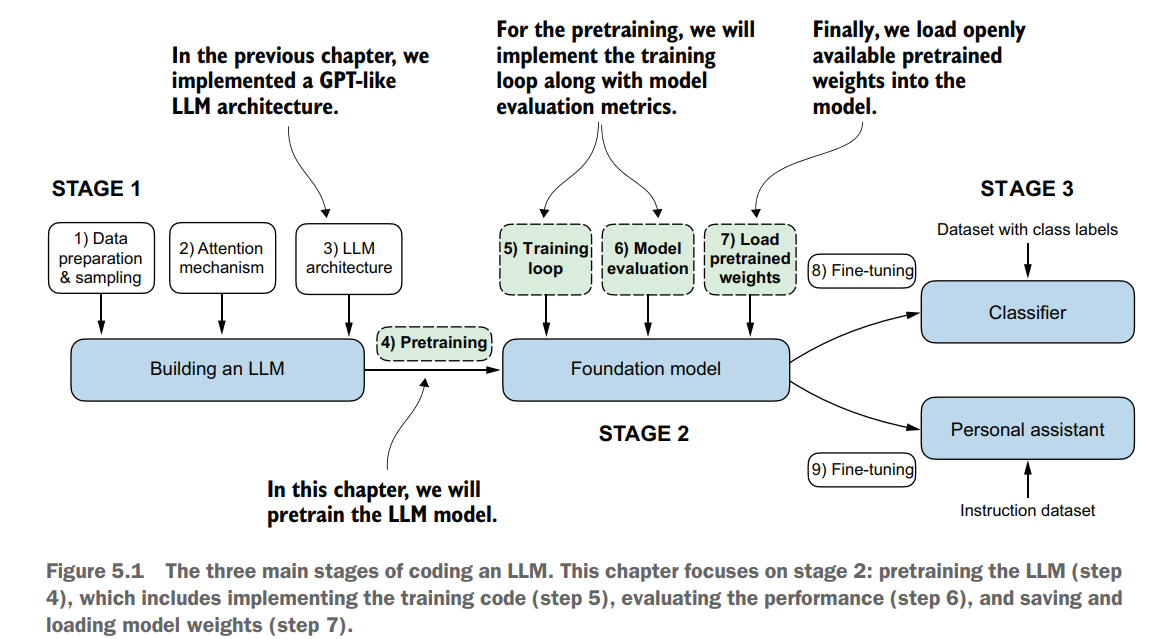

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [4]:
from utils.gpt import GPTModel

In [7]:
from utils.generator import generate_text_simple

In [8]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 256, # Context length # We shorten the context length from 1024 to 256 for faster training
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

To make our evaluation process simpler

We define two new functions `text_to_token_ids()` and `token_ids_to_text()` which are used in the text generation pipeline as illustrated by the following image:

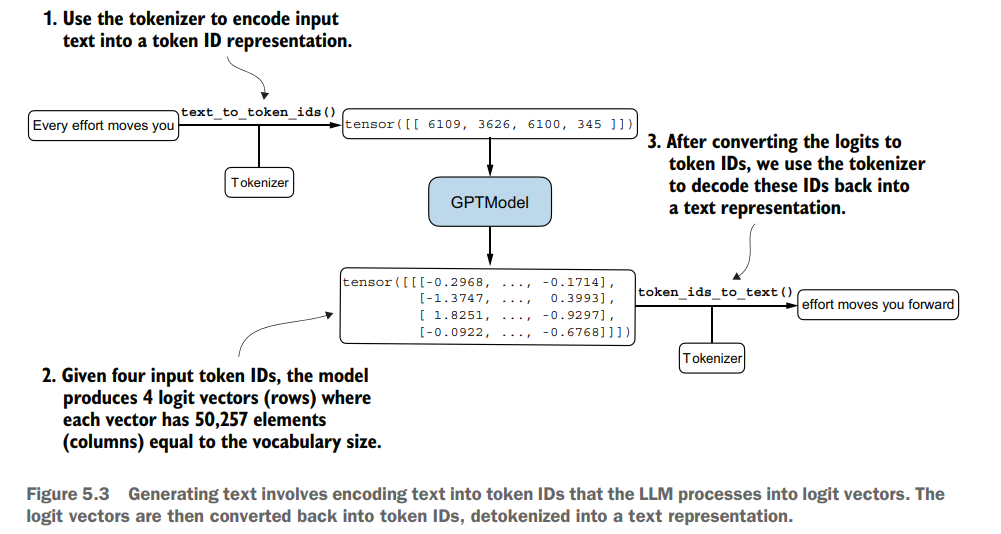

In [15]:
def text_to_token_ids(text, tokenizer):
    """
    Convert text to token ids using the tokenizer.
    """
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    """
    Convert token ids to text using the tokenizer.
    """
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [16]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

# Convert the start context to token ids

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic minion mobilized Macicone warrantyuler respirmediated


In [17]:
token_ids

tensor([[ 6109,  3626,  6100,   345, 34245,  5139, 28365, 50166,  4100, 27981,
         18215, 18173, 21483, 38363]])

### Building the intuition of loss function with simple example

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
 [40, 1107, 588]]) # "I really like"]

targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
 [1107, 588, 11311]]) # " really like chocolate"]


with torch.no_grad(): 
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) 
print(probas.shape) # (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [31]:
probas

tensor([[[2.5756e-05, 1.0833e-05, 1.6042e-05,  ..., 2.5733e-05,
          6.8686e-06, 1.6034e-05],
         [1.0105e-05, 9.4379e-06, 7.7280e-06,  ..., 4.0692e-05,
          5.7055e-06, 1.0792e-05],
         [3.2463e-05, 9.2218e-06, 1.6283e-05,  ..., 3.4169e-05,
          1.4085e-05, 1.1884e-05]],

        [[2.1001e-05, 1.7538e-05, 1.6416e-05,  ..., 1.1503e-05,
          5.3201e-05, 1.0935e-05],
         [7.0654e-06, 1.8018e-05, 9.2447e-06,  ..., 3.4000e-05,
          9.1224e-06, 1.5547e-05],
         [3.1890e-05, 3.1677e-05, 3.8751e-05,  ..., 6.9175e-06,
          5.5779e-05, 1.2184e-05]]])

In [ ]:
# Extract the index with the highest probability
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[36195],
         [16031],
         [42826]],

        [[14212],
         [ 7822],
         [38509]]])


In [28]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
 f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: lif savesNetflix


In [29]:
print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 2:"
 f" {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Targets batch 2:  really like chocolate
Outputs batch 2:  influential implementationBruce


From this example, we can see that to evaluate model's performance and write a loss fucntion we need to measure “how far” the generated tokens are from the correct predictions (targets). 

The model training aims to **increase the softmax probability in the index positions
corresponding to the correct target token IDs.**

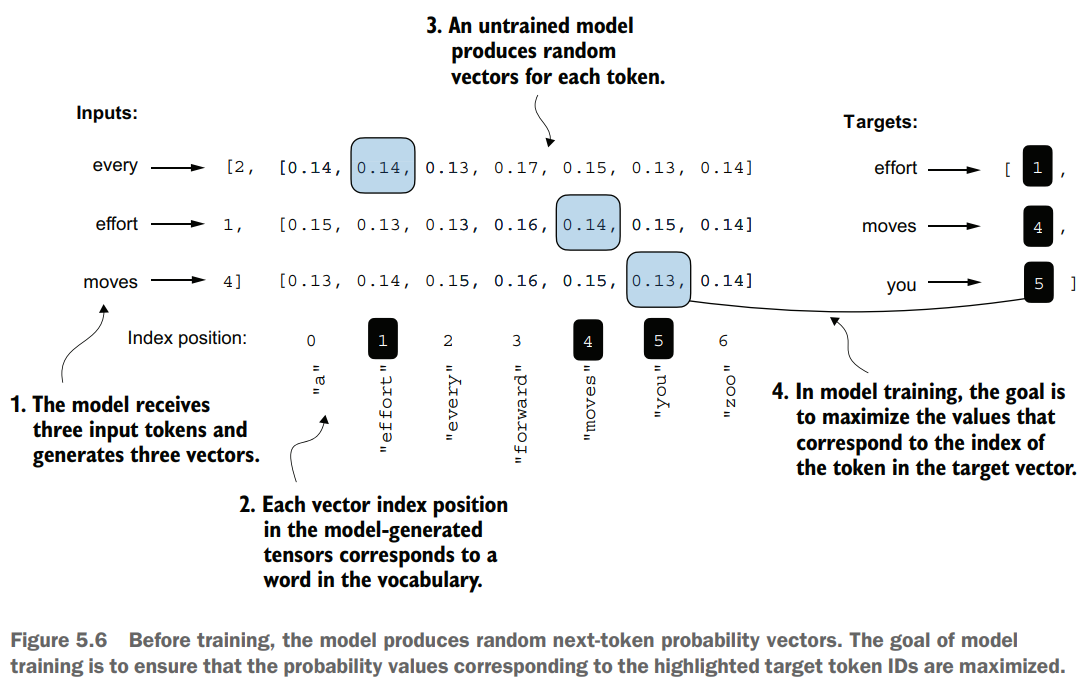

The figure only displays the softmax probabilities for a compact seven token vocabulary to fit everything into a single figure.

For each of the two input texts, we can print the **initial softmax probability scores** corresponding to the **target tokens** using the following code:



In [ ]:
# probas # (batch_size, seq_len/num_tokens, vocab_size)
# targets  # (batch_size, seq_len/num_tokens)

text_idx = 0
'''
Each element probas[i, j, k] represents the softmax probability 
of token k at position j in text i.
'''
target_probabs_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]  # Advanced indexing

'''
text_idx = 0 i.e. probabs[0,...] we're working with the first text's probabilities 
[0, 1, 2] has length 3 (selecting 3 positions).
targets[text_idx] must provide 3 token indices (or be broadcastable) to match the 3 positions.

For each position in [0, 1, 2], the corresponding target token index from 
targets[text_idx] is used to select a single probability from the vocabulary dimension.
'''
print("Text 1:", target_probabs_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)



Text 1: tensor([4.1353e-05, 1.9397e-05, 1.1213e-05])
Text 2: tensor([1.1875e-05, 4.1576e-05, 5.2655e-06])


In [ ]:
# Equivalent code of that advanced indexing (only for the first text)
text_idx = 0
pos = [0, 1, 2]
target_tokens = targets[text_idx][:3]
print(target_tokens) # Output: tensor([3626, 6100, 345])

result = []

for pos, token_idx in zip(pos, target_tokens):

    # print (pos, token_idx) 
    '''
    Output:
    0 tensor(3626)
    1 tensor(6100)
    2 tensor(345)
    '''
    prob = probas[text_idx, pos, token_idx] # Get probability of corresponding token according to target (3626, 6100, 345) for each token 
    result.append(prob)

target_probas_eqv = torch.tensor(result)
print(target_probas_eqv)

tensor([3626, 6100,  345])
tensor([4.1353e-05, 1.9397e-05, 1.1213e-05])


Right now we can see that the probabilities corresponding to the target tokens are **extemely small**. The goal of training thus is to get these values **as close to 1 as possible**.

We then merge the probabilties for all batches and then apply logarithm to those probability values for numerical stability and because we are actually applying CrossEntropy loss (after averaging).

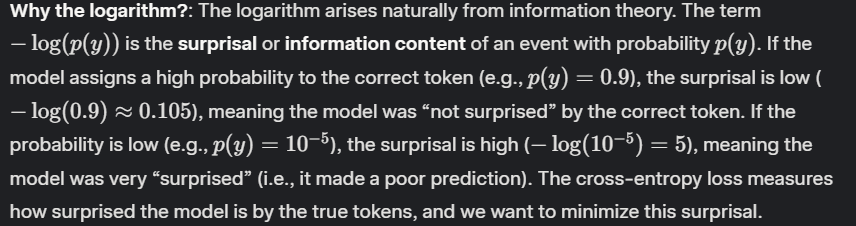

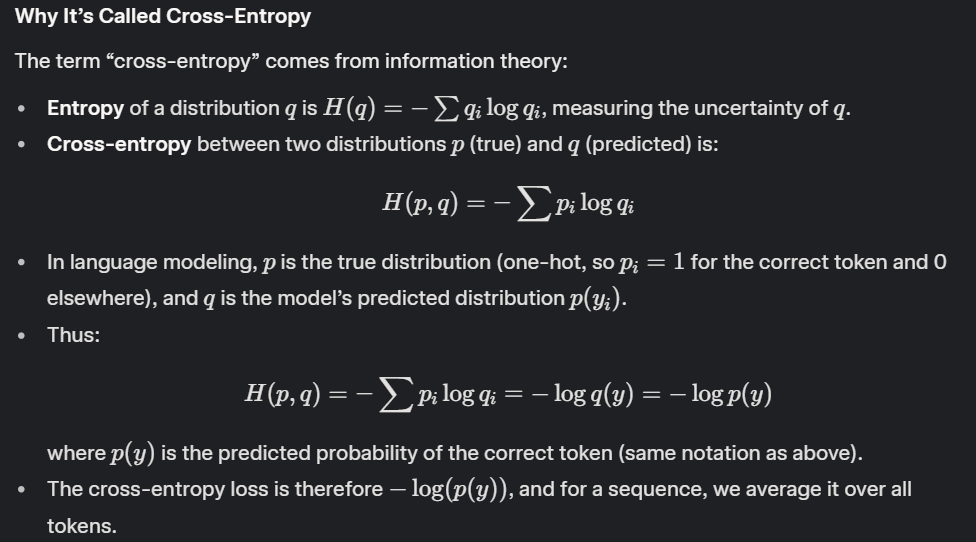

In [53]:
# target_probilities = torch.cat([target_probas_1, target_probas_2], dim = -1)
# print(target_probilities)

# logss = torch.log(target_probilities)
# print(logss)

# OR

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor([-10.0934, -10.8504, -11.3984, -11.3410, -10.0880, -12.1543])
tensor(-10.9876)


### Why we take negative of log value?

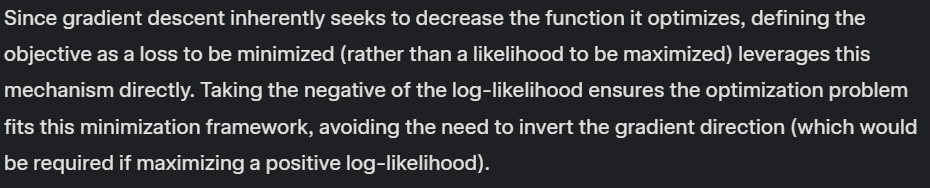

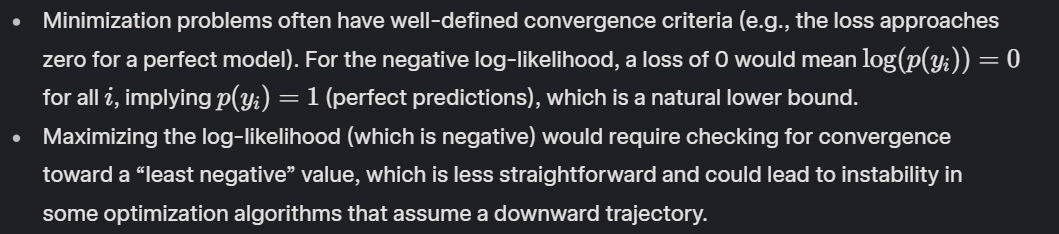

**Convention of early algorithms** and their inheritance in modern frameworks is also one reason

In [54]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.9876)


### Using Pytorch's cross entropy loss

This function does everything we did until now i.e:

The cross_entropy function in PyTorch combines two operations:

1. Softmax: Converts raw logits into probabilities.
2. Negative Log-Likelihood Loss (NLL Loss): Selects the probabilities for the target tokens, takes their log, averages them, and negates the result to compute the loss.


AND yes It **selects the probabilities** for the target tokens (equivalent to `probas[:, :, targets]` in a batched context).

#### Why do we need to flatten the logits and target tensors?

`F.cross_entropy` is designed for a simpler case: it expects a single prediction per sample (e.g., classification with (batch_size, num_classes) logits). In a language model, we have multiple predictions per sample (one per token in the sequence), so we need to reshape the tensors to fit this expectation:

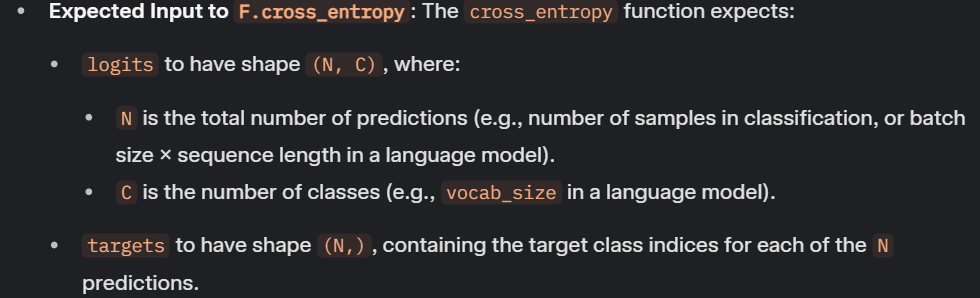

In [55]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [56]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

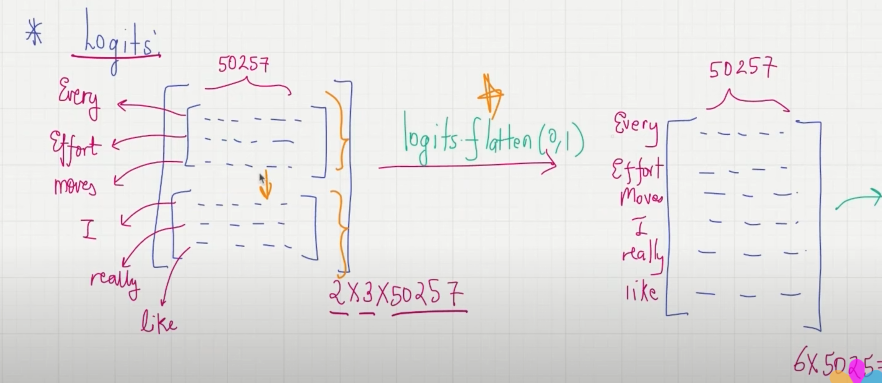

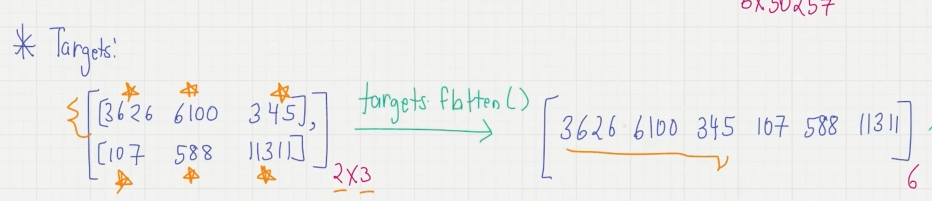

In [57]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [58]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.9876)


### Perplexity
Perplexity measures how well the probability distribution predicted by the model
matches the actual distribution of the words in the dataset. Similar to the loss, a lower
perplexity indicates that the model predictions are closer to the actual distribution.


Perplexity can be calculated as perplexity = `torch.exp(loss)`, which returns
tensor $(48725.8203)$ when applied to the previously calculated loss. 

Perplexity is often considered more interpretable than the raw loss value because it signifies the **effective vocabulary size about which the model is uncertain at each step**. 

In the given example, this would translate to the model being **unsure about which among
$48,725$ tokens in the vocabulary to generate as the next token**.

## Loss function for a toy dataset

We will be using "The verdict" story as our toy dataset

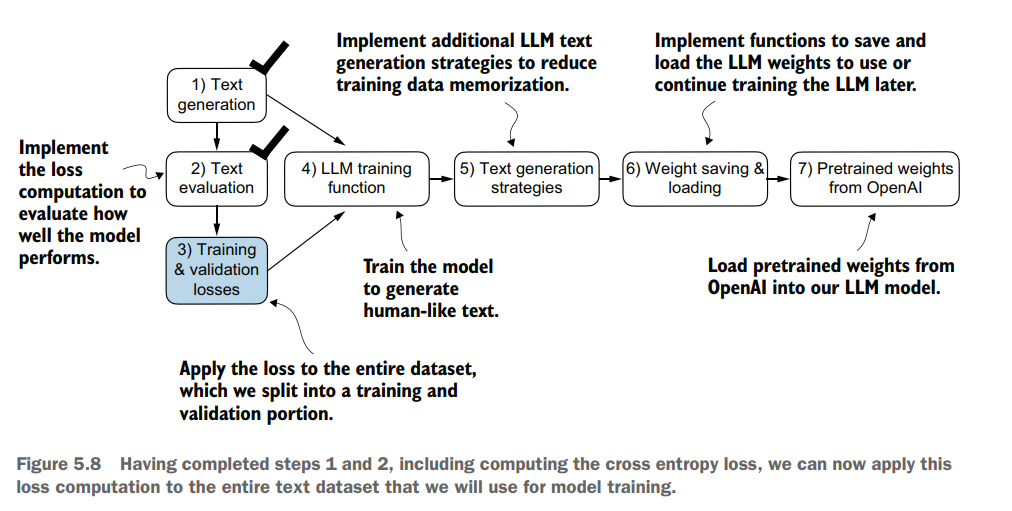

### Loading the dataset

In [67]:
cwd_path = os.getcwd()
# print(cwd_path)

parent_path = os.path.join(cwd_path, '..')
# This is a relative path that conceptually points to the 
# parent directory of chap_5, which is LLM

relative_file_path = os.path.join(parent_path, 'data', 'the_verdict.txt') # This is still a relative path with .. in it.
# Conceptually, it means: “Start in chap_5, 
# go up one directory to LLM, then go into data, and find the_verdict.txt.”

file_path = os.path.abspath(relative_file_path) # This resolves the relative path to an absolute path.
# print(file_path)

'''
When we use os.path.join(cwd_path, '..'), we're telling Python to construct a path that goes up one directory level.
The .. remains in the path string until it's resolved by a function like 
os.path.abspath() or when the file system interprets the path (e.g., during open()).
'''
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)


Characters: 20479
Tokens: 5145


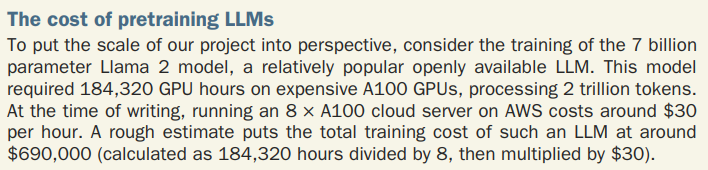


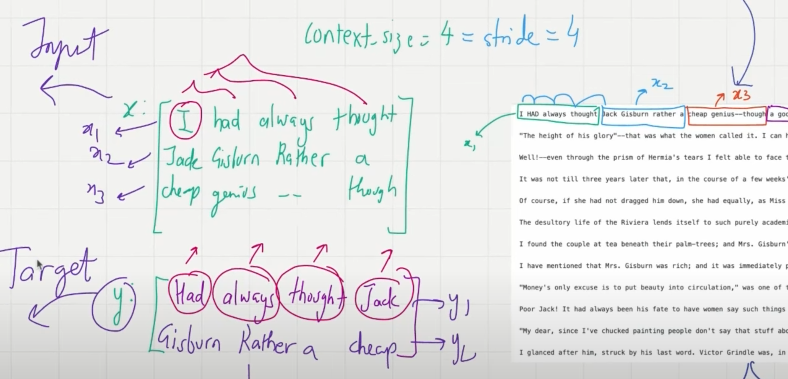

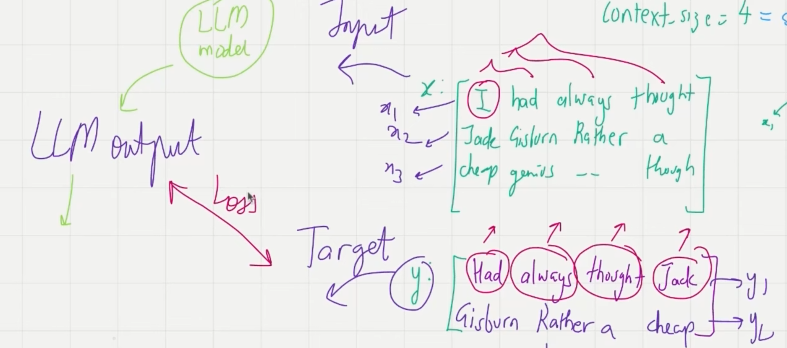

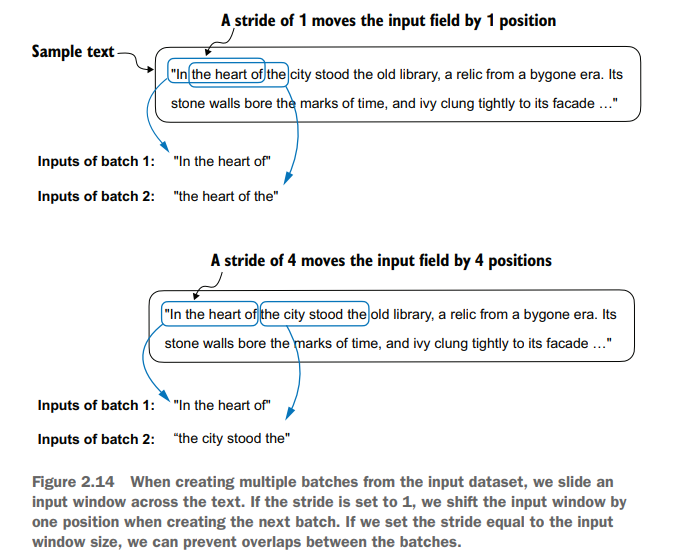

In [69]:
from torch.utils.data import Dataset, DataLoader

In [70]:
# Implementation from chap_2

class GPTDatasetV1(Dataset):

    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        # Loop over the token_ids to create input-target pairs with a sliding window
        # - Start at index 0
        # - Stop at len(token_ids) - max_length to ensure each input chunk has max_length tokens
        # - Increment by stride to control overlap between consecutive chunks

        '''
        The loop condition for i in range(0, len(token_ids) - max_length, stride) 
        ensures that we can extract valid input-target pairs of length 
        max_length without going out of bounds in the token_ids list.
        '''
        for i in range(0, len(token_ids) - max_length, stride):
            # Extract input chunk of max_length tokens starting at index i
            input_chunk = token_ids[i: i + max_length]

            # Extract target chunk, which is shifted by 1 token (for autoregressive prediction)
            # Starts at index i+1 and has the same length as input_chunk
            target_chunk = token_ids[i + 1: i + max_length + 1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In practice, it can also be beneficial to train an LLM with variable-length inputs to help the LLM to better generalize across different types of inputs when it is being used.

In [71]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [72]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
 stride=128, shuffle=True, drop_last=True,
 num_workers=1):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle = shuffle,
        drop_last = drop_last,
        num_workers = num_workers
    )

    return dataloader

In [77]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=4
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=4
)

We used a relatively small batch size to reduce the computational resource demand
because we were working with a very small dataset. In practice, training LLMs with
batch sizes of 1,024 or larger is not uncommon.

In [ ]:
print("Train loader:")

for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")

for x, y in val_loader:
    print(x.shape, y.shape)

# (Batch size, max_length_tokens)
# (9, 256) in this case for training set

Train loader:


torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Next, we implement a utility function to calculate the cross entropy loss of **a given
batch** returned via the training and validation loader:

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):

    input_batch = input_batch.to(device)
        
    target_batch = target_batch.to(device) # Input shifted by 1 token 

    logits = model(input_batch)
    # logits shape: (batch_size, nmax_length_tokens, vocab_size)
    # target_batch shape: (batch_size, nmax_length_tokens)

    # Flatten the logits and target_batch to compute the loss
    # logits shape: (batch_size * nmax_length_tokens, vocab_size)
    loss = torch.nn.functional.cross_entropy(
            logits.flatten(0, 1), target_batch.flatten()
    )
    
    return loss

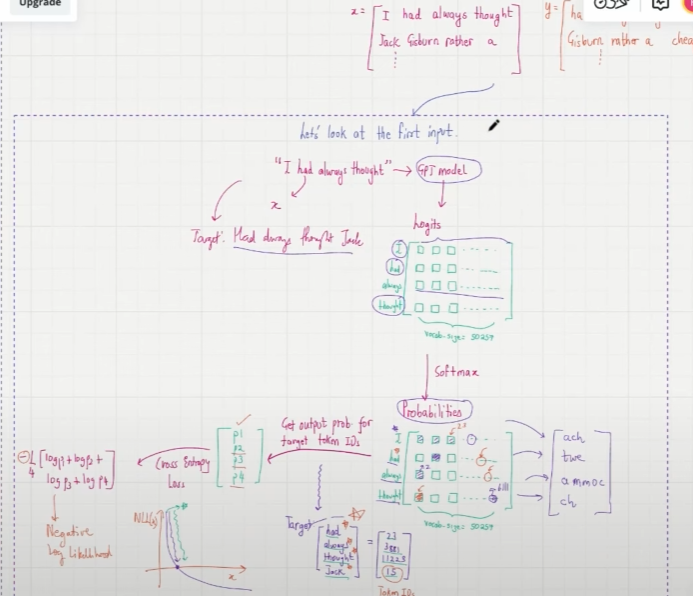

We can now use this `calc_loss_batch` utility function, which computes the loss for a
single batch, to implement the following `calc_loss_loader` function that computes
the loss over all the batches sampled by a given data loader.

In [80]:
def calc_loss_loader(data_loader, model, device, num_batches=None):

    total_loss = 0.

    
    if len(data_loader) == 0:
        # Data loader being empty means error in the dataset
        return float("nan")
        
    elif num_batches is None:
        # If num_batches is None, use the entire data loader
        # For example, in our case for train loader, it would be 9
        # and for val loader it would be 1
        num_batches = len(data_loader) 

    else:
        # If num_batches is specified, use the minimum of num_batches and the length of data_loader

        # Reduces the number of batches to match the total number of batches in the data
        # loader if num_batches exceeds the number of batches in the data loader

        num_batches = min(num_batches, len(data_loader)) 

    for i, (input_batch, target_batch) in enumerate(data_loader):

        if i < num_batches:
            # Calculate the loss for each batch
            loss = calc_loss_batch(
                    input_batch, target_batch, model, device
            )
            # Sum the loss for each batch
            total_loss += loss.item() 
        else:
            break

    return total_loss / num_batches

### Using the above created loss function

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [82]:
with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, model, device) 
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583690219456
Validation loss: 10.982393264770508
